DD KolektorSDD2

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
import cv2
import os
import numpy as np

# Set the path to the dataset directory
train_dataset_dir = 'dataset/train'
test_dataset_dir = 'dataset/test'

# Initialize empty arrays for storing the images and masks
images = []
masks = []

# Loop over the files in the dataset directory
for filename in os.listdir(train_dataset_dir):
    if filename.endswith('GT.png'): # Check if the file is an image
        mask_path = os.path.join(train_dataset_dir, filename)
        image_path = os.path.join(train_dataset_dir, filename[:-7]+'.png') # Assumes that the mask file is named "mask_<image_filename>.jpg"
        
        # Load the image and mask using OpenCV
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)
        
        # Convert the mask to a binary image
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.where(mask > 0, 1, 0)
        
        # Append the image and mask to the arrays
        images.append(image)
        masks.append(mask)
        
# Convert the image and mask arrays to numpy arrays
images = np.array(images)
masks = np.array(masks)

/tmp/ipykernel_3674/1803878209.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)
/tmp/ipykernel_3674/1803878209.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array(masks)


In [8]:
# Create an enumerator for both the images and masks
for i, (image_value, mask_value) in enumerate(zip(images, masks)):
    # Do something with the image and mask values
    # For example, print the index and value of the image and mask
    print(f"Index {i}, Image value: {image_value}, Mask value: {mask_value}")


Index 0, Image value: [[[ 31  24  28]
  [ 19  18  16]
  [ 20  20  18]
  ...
  [ 42  45  45]
  [ 39  41  45]
  [ 44  44  46]]

 [[ 23  20  19]
  [ 22  20  19]
  [ 25  24  23]
  ...
  [ 46  44  47]
  [ 38  39  42]
  [ 43  43  42]]

 [[ 19  19  24]
  [ 34  28  25]
  [ 25  27  28]
  ...
  [ 43  39  40]
  [ 36  34  35]
  [ 42  43  44]]

 ...

 [[ 35  30  23]
  [ 33  27  31]
  [ 33  25  25]
  ...
  [ 75  74  66]
  [ 63  56  51]
  [ 51  44  35]]

 [[ 38  29  23]
  [ 29  33  30]
  [ 39  43  36]
  ...
  [ 99  97 118]
  [ 94  86  76]
  [ 71  68  62]]

 [[ 30  28  30]
  [ 34  36  40]
  [ 65  62  58]
  ...
  [ 86  73  69]
  [ 98  88  85]
  [ 80  71  66]]], Mask value: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Index 1, Image value: [[[11 10 13]
  [20 17 13]
  [17 16 16]
  ...
  [31 26 22]
  [26 27 28]
  [32 32 39]]

 [[ 7  8 11]
  [17 15 13]
  [15 15 13]
  ...
  [38 30 27]
  [31 26 24]
  [31 26 24]]

 [[ 6 10 10]
  [21 20

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Define model architecture
model = Sequential()

# Encoder (downsampling)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

# Decoder (upsampling)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

# Output layer (binary segmentation mask)
model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [25]:
import os
import cv2
import glob
import numpy as np



# Set the path to the dataset directory
dataset_dir = 'dataset/'

# Define image and mask data lists
image_files = glob.glob(os.path.join(dataset_dir, '*.png'))
mask_files = [f for f in image_files if f.endswith('_GT.png')]
image_files = [f for f in image_files if not f.endswith('_GT.png')]

# Load images and masks
image_data = []
mask_data = []
for image_file, mask_file in zip(image_files, mask_files):
    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    image_data.append(image)
    mask_data.append(mask)

# Convert data to numpy arrays
image_data = np.array(image_data)
mask_data = np.array(mask_data)

# Normalize image data
image_data = image_data.astype('float32') / 255.0


# Train the model
log = model.fit(
    image_data,
    mask_data,
    batch_size=32,
    epochs=10,
    verbose=1
)

# Evaluate the model
model.evaluate(
    image_data,
    mask_data,
    verbose=1
)

Epoch 1/10


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

Visualisation of the dataset

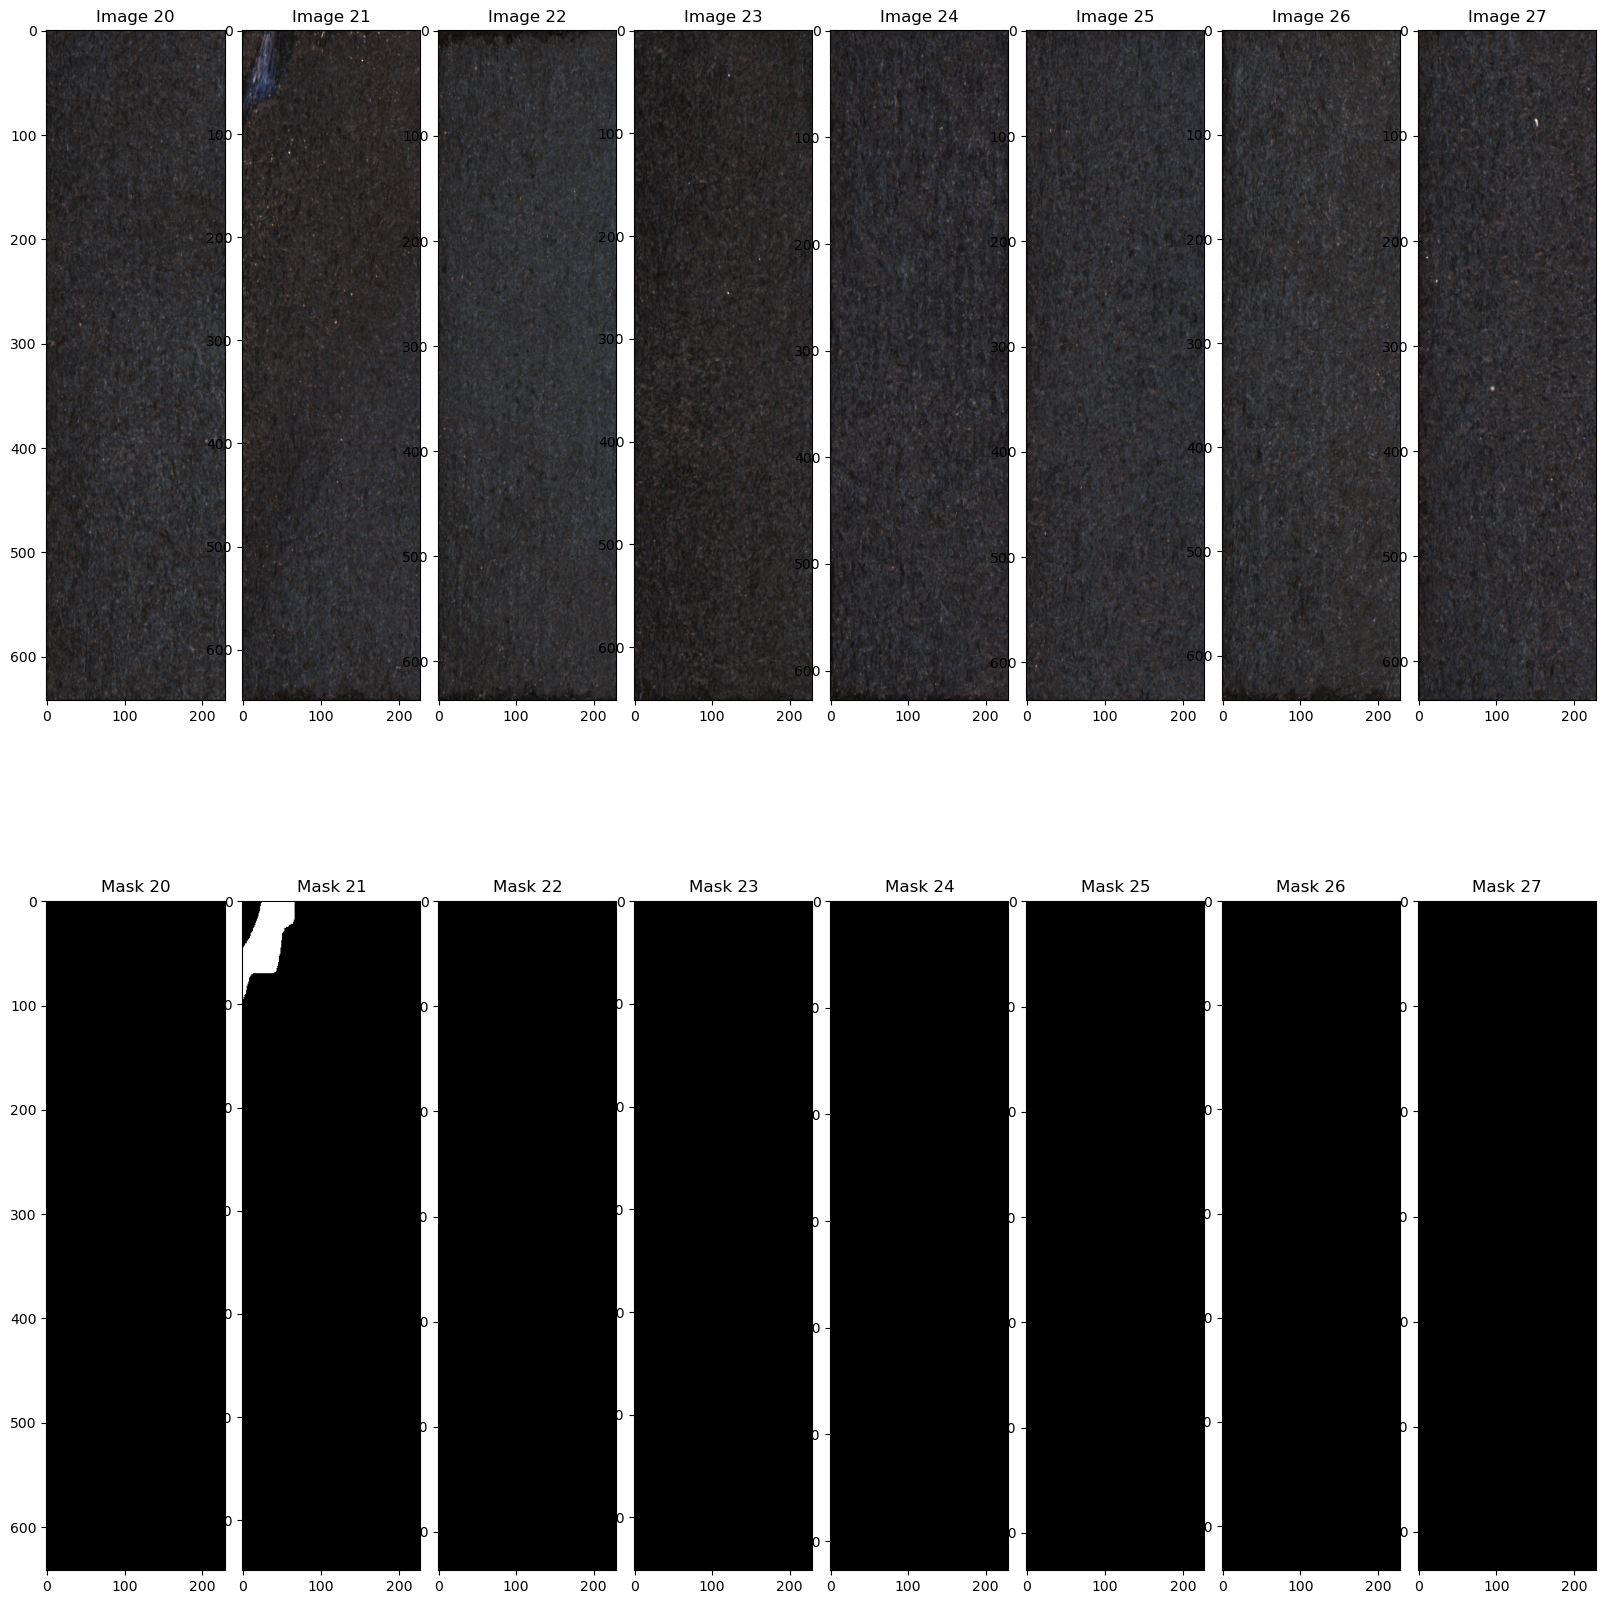

In [7]:
from utils import show_images_with_masks
start_index = 20
num_imgs = 8
end_index = start_index + num_imgs

show_images_with_masks(images, masks, start_index, end_index)